In [1]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.gaia import Gaia
from lightkurve import search_targetpixelfile
import matplotlib.pyplot as plt
import numpy as np
import raDec2Pix


Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
quarter = 5

kepid = 4752451
koi = 109.01
RA = "19h33m49.03s"
dec = "+39d48m14.1s"
c = SkyCoord(RA, dec, frame='icrs')
print([c.ra.degree, c.dec.degree])

period = 6.41496453
epoch = 132.86482
durationHours = 3.9015

# BKJD = BJD-2454833.0, MJD = JD-2400000.5, so MJD = BKJD + 2454833.0 - 2400000.5 = BKJD + 54832.5
mjdOffset = 54832.5

[293.4542916666666, 39.803916666666666]


In [3]:
tpf = search_targetpixelfile('KIC ' + str(kepid), quarter = quarter).download();
extent = (tpf.column-0.5, tpf.column + tpf.shape[2]-0.5, tpf.row-0.5, tpf.row + tpf.shape[1]-0.5)
mjd = np.mean(tpf.time) + mjdOffset

In [7]:
print(tpf.time)

transitTimes = [];
firstTransitTime = np.ceil((tpf.time[0] - epoch)/period)*period + epoch
print(firstTransitTime)
n = np.ceil((tpf.time[0] - epoch)/period);
while epoch + n*period < tpf.time[-1]:
    transitTimes = np.append(transitTimes, epoch + n*period)
    n = n+1;
print(transitTimes)

[443.48993762 443.51037205 443.53080628 ... 538.10163515 538.12206953
 538.16293799]
447.19808197
[447.19808197 453.6130465  460.02801103 466.44297556 472.85794009
 479.27290462 485.68786915 492.10283368 498.51779821 504.93276274
 511.34772727 517.7626918  524.17765633 530.59262086 537.00758539]


[447.1885548  453.60495672 460.02137702 466.43781229 472.85425903
 479.27071086 485.68717091 492.10363202 498.52009091 504.93654403
 511.35298848 517.76942096 524.18583855 530.60223836 536.99818362]


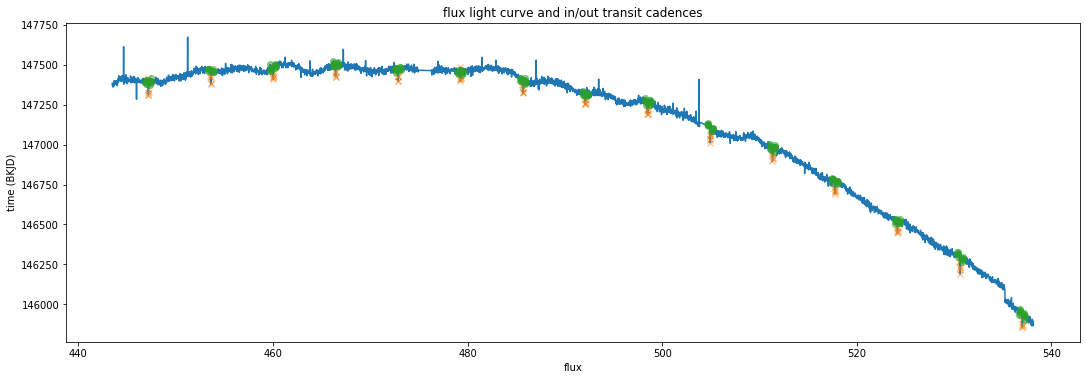

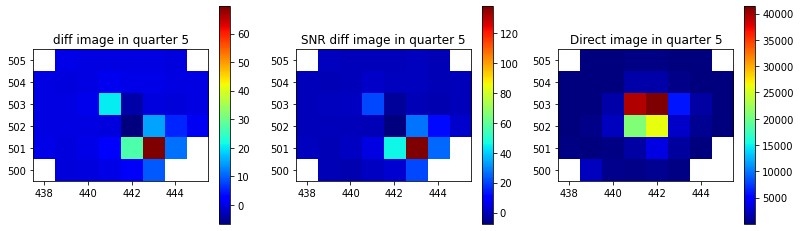

In [8]:

transitIndex = [];
for t in transitTimes:
    transitIndex = np.append(transitIndex, np.abs(tpf.time - t).argmin())
transitIndex = transitIndex.astype(int)
print(tpf.time[transitIndex])
inTransitIndices = [];
for i in transitIndex:
    inTransitIndices = np.append(inTransitIndices, i + np.arange(-durationHours+1,durationHours-1))
inTransitIndices = inTransitIndices.astype(int)

nInTransit = len(np.arange(-durationHours+1,durationHours-1))
buffer = 5
outTransitIndices = [];
for i in transitIndex:
    outTransitIndices = np.append(outTransitIndices, i + np.arange(-durationHours - buffer - nInTransit,
                                                 -durationHours - buffer).astype(int));
    outTransitIndices = np.append(outTransitIndices, i + np.arange(durationHours + 1 + buffer ,
                                                 durationHours + 1 + buffer + nInTransit));
outTransitIndices = outTransitIndices.astype(int)

lc = tpf.to_lightcurve()
lc = lc.remove_nans();
corr_lc = lc.remove_outliers()

windowBuff = 40;
plt.figure(figsize=(15, 5));
plt.plot(corr_lc.time, corr_lc.flux)
# plt.plot(corr_lc.time[transitIndex], corr_lc.flux[transitIndex], '*')
plt.plot(corr_lc.time[inTransitIndices], corr_lc.flux[inTransitIndices], 'x', alpha = 0.6)
plt.plot(corr_lc.time[outTransitIndices], corr_lc.flux[outTransitIndices], 'o', alpha = 0.5)
thisI = 3
# plt.xlim(corr_lc.time[transitIndex[thisI]] - 3*durationHours/24, corr_lc.time[transitIndex[thisI]] + 3*durationHours/24)
plt.tight_layout();
plt.xlabel("flux");
plt.ylabel("time (BKJD)");
plt.title("flux light curve and in/out transit cadences");

meanInTransit = np.mean(tpf.flux[inTransitIndices,::-1,:], axis=0)
meanInTransitSigma = np.sqrt(np.mean(tpf.flux_err[inTransitIndices,::-1,:]**2, axis=0)/len(inTransitIndices))
meanOutTransit = np.mean(tpf.flux[outTransitIndices,::-1,:], axis=0)
meanOutTransitSigma = np.sqrt(np.mean(tpf.flux_err[outTransitIndices,::-1,:]**2, axis=0)/len(outTransitIndices))

fig = plt.figure(figsize=plt.figaspect(0.3));
ax = fig.add_subplot(1, 3, 1)
plt.imshow(meanOutTransit-meanInTransit, extent=extent, cmap='jet')
plt.colorbar()    
plt.title("diff image in quarter " + str(quarter));

ax = fig.add_subplot(1, 3, 2)
plt.imshow((meanOutTransit-meanInTransit)/np.sqrt(meanInTransitSigma+meanOutTransitSigma), 
           extent=extent, cmap='jet')
plt.colorbar()    
plt.title("SNR diff image in quarter " + str(quarter));

ax = fig.add_subplot(1, 3, 3)
plt.imshow(np.mean(tpf.flux[outTransitIndices,::-1,:], axis=0), extent=extent, cmap='jet')
plt.colorbar()    
plt.title("Direct image in quarter " + str(quarter));


In [9]:
coord = SkyCoord(ra=c.ra.degree, dec=c.dec.degree, unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity((np.linalg.norm([tpf.shape[1], tpf.shape[2]]))*4/3600/2 , u.deg)
j = Gaia.cone_search_async(coord, radius)
gaiaCatalog = j.get_results()


    solution_id             designation          ...          dist         
                                                 ...                       
------------------- ---------------------------- ... ----------------------
1635721458409799680 Gaia DR2 2053230698073349632 ... 1.8184781541507842e-05
1635721458409799680 Gaia DR2 2053230693772073600 ...  0.0020413805607640235
1635721458409799680 Gaia DR2 2053230698064783744 ...  0.0022532571569372946
1635721458409799680 Gaia DR2 2053230590691354112 ...   0.002602196813556672
1635721458409799680 Gaia DR2 2053230698064796544 ...  0.0035653334252524686
1635721458409799680 Gaia DR2 2053230698064798208 ...   0.004366152031369277
1635721458409799680 Gaia DR2 2053230526266081024 ...   0.004737169108610334
1635721458409799680 Gaia DR2 2053230594994131584 ...   0.004957016148524368


In [11]:
rdp = raDec2Pix.raDec2PixClass("raDec2PixDir")
[mod, out, row, column] = rdp.ra_dec_2_pix(gaiaCatalog["ra"], gaiaCatalog["dec"], mjd)
[m, o, targetRow, targetCol] = rdp.ra_dec_2_pix(c.ra.degree, c.dec.degree, mjd)

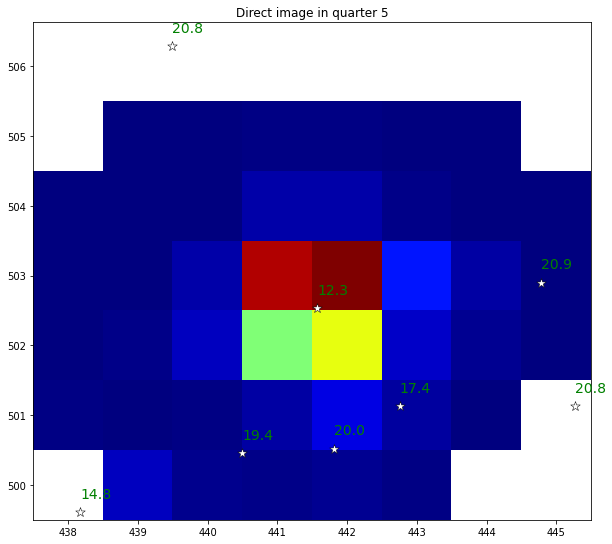

In [23]:
fig = plt.figure(figsize = (10,10));
plt.imshow(np.mean(tpf.flux[outTransitIndices,::-1,:], axis=0), extent=extent, cmap='jet')
plt.title("Direct image in quarter " + str(quarter));
for s in range(len(mod)):
    plt.scatter(column[s], row[s], s=100, marker="*", color="w", edgeColor="k", linewidths=0.5)
    plt.text(column[s], row[s] + 0.2, str(np.round(gaiaCatalog["phot_g_mean_mag"][s],1)), color="g", fontsize = 14)


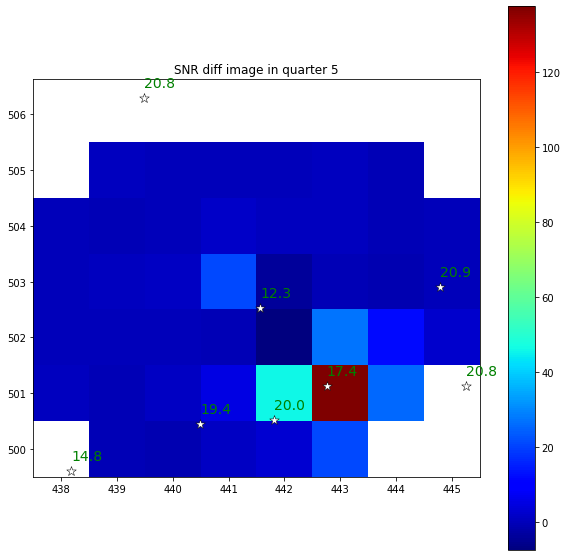

In [22]:
fig = plt.figure(figsize = (10,10));
plt.imshow((meanOutTransit-meanInTransit)/np.sqrt(meanInTransitSigma+meanOutTransitSigma), 
           extent=extent, cmap='jet')
plt.colorbar()    
plt.title("SNR diff image in quarter " + str(quarter));
for s in range(len(mod)):
    plt.scatter(column[s], row[s], s=100, marker="*", color="w", edgeColor="k", linewidths=0.5)
    plt.text(column[s], row[s] + 0.2, str(np.round(gaiaCatalog["phot_g_mean_mag"][s],1)), color="g", fontsize = 14)


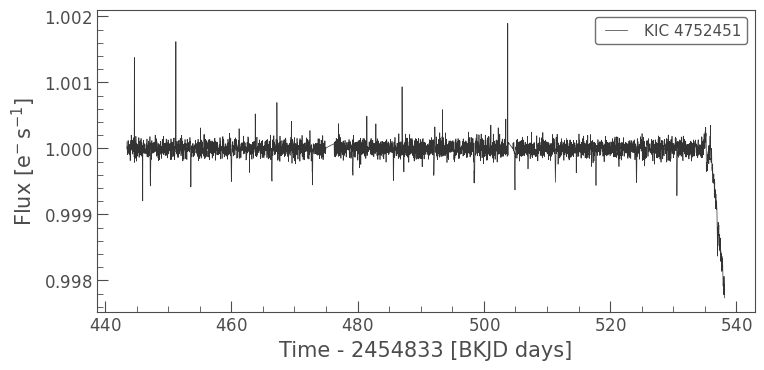

In [24]:
lc = tpf.to_lightcurve().flatten();
lc.plot();


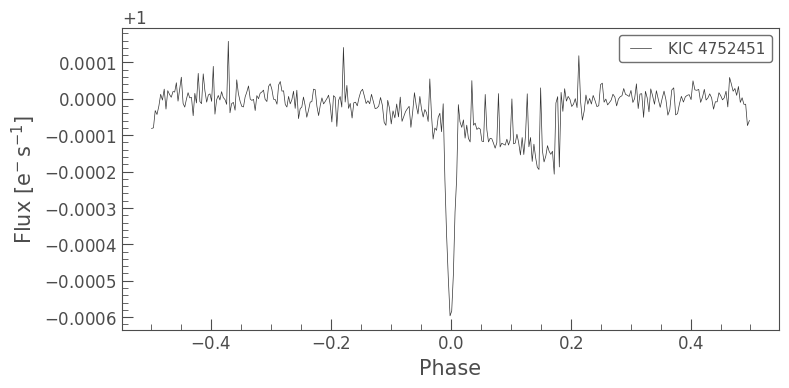

In [34]:
# plot it folded
lc.fold(period = period, t0=epoch).bin().plot()
# plt.ylim(1-30e-3, 1+30e-3);

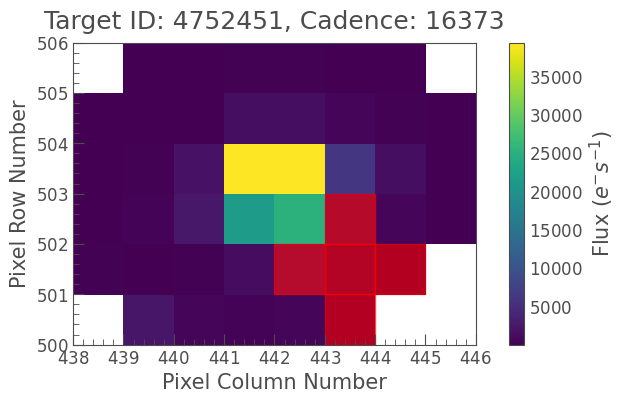

In [27]:
# do photometry with a new aperture
# will need a different aperture for each quarter
aper = np.zeros(tpf.shape[1:], dtype=np.int)
aper[1,5] = 1
aper[1,4] = 1
aper[1,6] = 1
aper[0,5] = 1
aper[2,5] = 1
tpf.plot(aperture_mask=aper, mask_color='red');


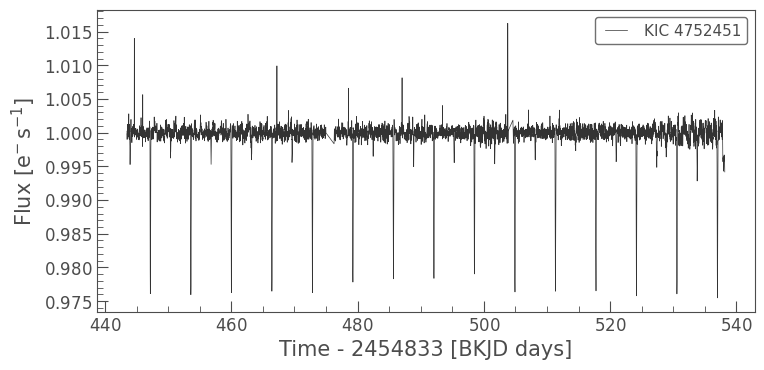

In [29]:
# make a light curve for this quarter using the improved aperture
lcq = tpf.to_lightcurve(aperture_mask=aper.astype(bool)).flatten();
lcq.remove_nans().remove_outliers();
lcq.plot();


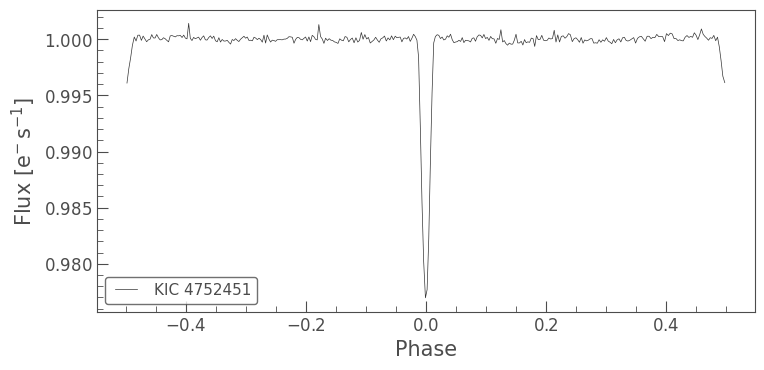

In [33]:
# plot it folded
lcq.fold(period = period, t0=epoch).bin().plot()
# plt.ylim(1-30e-3, 1+30e-3);